#### **API 키 설정**

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "내 OPENAI API 키"
os.environ['TAVILY_API_KEY'] = "내 TAVILY API 키"

#### **WebBaseLoader로 웹페이지 내 텍스트를 Vector DB로 저장하고 Retriever로 만들기**

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# 텍스트를 가져올 url
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB (크로마db에 저장)
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

# 리트리버로 만들기
retriever = vectorstore.as_retriever()

#### **문서 관련성 검토 함수 정의하기**

문서로 검색이되면 이것이 사용자의 질문과 관련이 있는지 확인하기 위해서 문서 관련성 검토 함수를 정의.

In [ ]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
# 사용자의 질문이 들어왔을 때, 그 검색된 문서와 관련성을 검토한 결과 관련이 있으면 'yes' 없으면 'no'를 나오게 스트럭쳐 아웃풋을 만들어줌
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

#### **답변 작성 Chain 정의하기**

In [ ]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

#### **질문 재작성 Chain 정의하기**

In [52]:
### Question Re-writer (질문을 재작성하는 체인 정의하기)

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# 질문을 재작성하는 체인의 경우에는 system메세지와 human메세지를 re_write_prompt로 하나로 묶어서 LLM과 연결을 시킨다음 question_rewriter라는 체인으로 정의
question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is agent memory and how does it function in artificial intelligence?'

#### **웹 검색 툴 설정**

In [54]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

# TavilySearchResults는 랭체인에서 미리 사전에 정의한 Tool을 사용
web_search_tool = TavilySearchResults(k=3) # 원하는 수만큼 가져오면되는데, 
                                           # 너무 많이 가져오면 LLM이 답변을 생성할때 ContextWindowt사이즈가 너무 커질 수 있기때문에 무한정으로 크게하는건 추천하지 않음.
                                           # 10개 ~ 20개 사이 까지는 많이 늘려서 활용함. (우선 테스트로 3개까지만)

#### **GraphState 정의하기**

In [56]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str # web_search 키값 추가
    documents: List[str]

#### **위에서 정의한 Chain을 기반으로 노드 함수 정의하기**

In [58]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"] # 사용자의 질문을 question으로 가져옴
    documents = state["documents"] # 위 retrieve함수에서 얻어낸 "documents"값을 가져와 documents에 저장

    # RAG generation
    # rag_chain을 invoke할 때 "context"와 "question" 매개변수에 각각 documents와 question을 넣어줌
    generation = rag_chain.invoke({"context": documents, "question": question}) #  (이렇게 invoke를 하면 주저인 벡터db에서 뽑아낸 관련문서들과 사용자의 질문을 활용한 LLM의 답변을 받아볼 수 있음)
    return {"documents": documents, "question": question, "generation": generation} # ⬆️ 이것을 "generation" 키값에 저장

# 문서관련성 검토 함수
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = [] # 필터문서 빈 리스트 선언
    web_search = "No" # 초기값으로 웹서치는 no
    for d in documents: # 검색된 문서들을 for문으로 순회
        score = retrieval_grader.invoke( # retrieval_grader를 통해 사용자의 질문이 관련성이 있는지 판단함 (retrieval_grader를 invoke로 실행시키면 yes 또는 no가 나옴)
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score # grade에 저장 (키값을 binary_score로 불러와야 yes인지 no인지 확인할 수 있음)
        if grade == "yes": # 사용자의 질문이 문서와 관련이 있을 때
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d) # 필터문서 리스트에 추가
        else: # 관련이 없으면 
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes" # 웹서치가 Yes로 활성화 시킨후 하나라도 검색한 문서중에 사용자의 질문과 무관한게 있다면 웹검색을 실행할 수 있도록 state값을 업데이트 해줌
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search} # 사용자 질문에 관련이 있으면 web_search에 No가 들어가고 아니면 Yes가 State값에 전달이 된다.


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question}) # 사용자의 초기질문을 더 나아진 질문으로 바꿔줌
    return {"documents": documents, "question": better_question}

# 더 나아진 질문은 web_search에서 활용을 하게 된다.
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    # 더 나은 사용자의 질문을 기반으로해서 웹검색을 다시 하게됨
    docs = web_search_tool.invoke({"query": question}) # web_search_tool은 최대 3개까지만 가져오게 설정함 (맨 위)
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"] # 웹검색을 해야되는지에 대한 여부

    if web_search == "Yes": # Yes면
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query" # 웹검색을 해야하면 transform_query노드 실행
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate" # 사용자 질문가 전부 관련이 있다면 generate 노드 실행

#### **그래프 구축하기**

In [60]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
# 위에서 선언한 5가지 함수를 선언
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve") # 사용자의 질문이 들어왔을때, 바로 문서 검색을 함
workflow.add_edge("retrieve", "grade_documents") # 그리고 문서관련성을 검토
workflow.add_conditional_edges( # 검토한 결과를 conditional_edges 추가
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query", # 질문을 재작성해서 웹검색으로 넘겨야하면 transform_query 출력
        "generate": "generate", # 그렇지 않으면 generate
    },
)
workflow.add_edge("transform_query", "web_search_node") # 질문이 재작성되면 문조건 web_search_node로 넘어가게끔
workflow.add_edge("web_search_node", "generate") # 웹검색 결과가 나오면 검토할게 없으니 generate 노드 실행
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

#### **그래프 시각화**

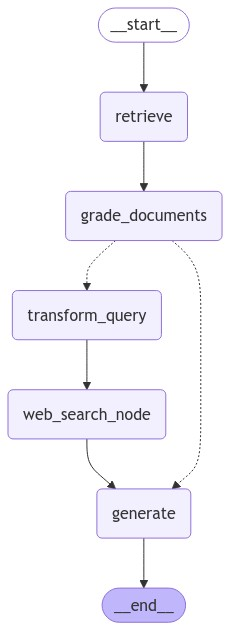

In [62]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [64]:
# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
print(value["generation"])

---RETRIEVE---
Node 'retrieve':

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
Node 'grade_documents':

---

---TRANSFORM QUERY---
Node 'transform_query':

---

---WEB SEARCH---
Node 'web_search_node':

---

---GENERATE---
Node 'generate':

---

The different types of agent memory in artificial intelligence include simple reflex agents, which act based solely on current percepts without memory, and limited memory agents, which can learn from recent experiences. Additionally, there are table-driven agents that use a lookup table to determine actions based on percept sequences. Other types include model-based agents, goal-based agents, utility-based agents, and learning agents, each with varying degrees of memory and adaptability.


질문을 했더니 ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY 라고 나오는걸 볼 수 있다.

모든 문서가 질문과 관련이 없어서 TRANSFORM QUERY를 실행하겠다 라고하면서 쿼리를 바꾼 후 WEB SEARCH 노드를 실행 한다.

그리고 웹검색을 기반으로 해서 LLM이 답변을 하고 있는 걸 볼 수 있다.

기존의 벡터DB만을 통해서 RAG시스템을 구축할 때 겪었던 어려움이 있다.

이 웹검색 노드를 하나 붙이는것 만으로도 기존의 조금 부족했던 답변들을 충분히 많이 보완할 수 있다는 점이 있다.